In [1]:
import numpy as np
import pandas
import pm4py
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
import scipy.stats as stats
from sklearn.model_selection import train_test_split

pandas.set_option('display.max_rows', 10000)

In [2]:
n = 100
data = pandas.DataFrame.from_dict({
        'after_noon' : [0]*5*n + [1]*n + [2]*n + [3]*n + [4]*n + [5]*5,
        'bullshit' : np.random.choice([0,1,2], n*9+5),
        'processing_time' : 
            list(
                np.where(np.random.choice(a=[0, 1], size=5*n, p=[0.5, 0.5]),
                         np.random.normal(2.2, 0.2, 5*n),
                         np.random.normal(6, 0.2, 5*n)
                )
            ) + list(
                np.random.normal(2, 0.2, n)
            )
             + list(
                        np.random.normal(4, 0.2, n)
                    )
            + list(
                    np.random.uniform(0,10, n)
            )
            + list(
                np.where(np.random.choice(a=[0,1], size=n, p=[5/8, 3/8]),
                    np.where(np.random.choice(a=[0, 1], size=n, p=[0.5, 0.5]),
                             np.random.normal(2.2, 0.2, n),
                             np.random.normal(6, 0.2, n)
                    ),06436766287925
                    np.where(np.random.choice(a=[0,1], size=n, p=[1/3, 2/3]),
                        np.random.normal(2, 0.2, n),
                        np.where(np.random.choice(a=[0,1], size=n, p=[1/2, 1/2]),
                            np.random.normal(4, 0.2, n),
                            np.random.uniform(0,10,n)
                        )
                    )
                )
            )
            + list(np.random.normal(4, 0.2, 5))
            
})

In [3]:
train, test = train_test_split(data, test_size=0.01)

In [4]:
train[train['after_noon'] == 5]

,after_noon,bullshit,processing_time
901,5,1,4.215947
902,5,2,3.960888
903,5,2,4.069509
904,5,0,3.824836
900,5,1,3.949304


<Axes: >

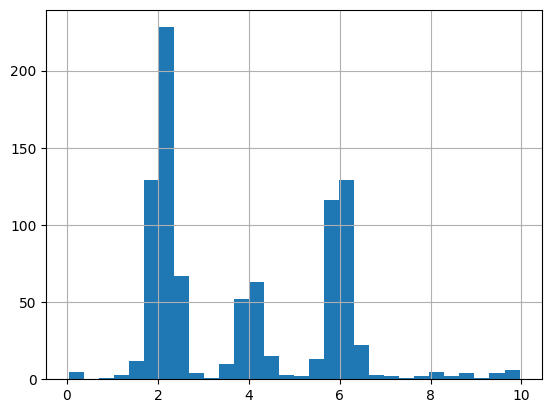

In [5]:
data['processing_time'].hist(bins=30)

In [9]:
class GMM:
    def __init__(self, start_end_event_log, n=10, percentile=False):
        self.durations = start_end_event_log['processing_time'].to_numpy()
        self._get_x(start_end_event_log, percentile)
        self.gmm = self.get_gmm(self.x, n)

    def _get_x(self, durations, percentile):
        if percentile:
            self.durations = self.durations[self.durations <= np.percentile(self.durations, percentile)]
        self.x = np.ravel(self.durations).astype(np.float64).reshape(-1,1)
    
    def get_gmm(self, x, n):
        mm = GaussianMixture(n,
                             covariance_type='full',
                             n_init=1000,
                             #covariance_type='spherical',
                             init_params='k-means++',
                             #init_params='kmeans',
                             #init_params='random_from_data',
                             #init_params='random',
                             max_iter=1000
                            )
        mm.fit(x)
        return mm

    def get_pdf_values(self, f_axis):
        X = np.ravel(f_axis).astype(np.float64).reshape(-1,1)
        pdf = lambda x : sum([weight * stats.norm.pdf(x, mean, np.sqrt(cov))[0] \
                              for weight, mean, cov in zip(self.gmm.weights_, self.gmm.means_, self.gmm.covariances_)])
        return np.array([pdf(x) for x in X]).flatten()

    def goodness(self):
        bic = self.gmm.bic(self.x)
        return bic

    def plot_gmm(self, other_gmm=None, show_all=True, percentile=False):
        # remove outliers
        if percentile:
            pruned_durations = self.durations[self.durations <= np.percentile(self.durations, percentile)]
        else:
            pruned_durations = self.durations
        f_axis = np.linspace(max(0, pruned_durations.min()-10), pruned_durations.max(), 10000)
        predictions = self.get_pdf_values(f_axis)
        plt.plot(f_axis, predictions)
        
        gmm_samples, _ = self.gmm.sample(100000)
        plt.hist(gmm_samples, bins=min(200, int(len(self.x))), histtype='bar', density=True, alpha=0.5, range=(pruned_durations.min(), pruned_durations.max()))
        #predictions = np.exp(self.gmm.score_samples(np.ravel(f_axis).astype(np.float64).reshape(-1,1)))
        #plt.plot(f_axis, predictions)
        if show_all:
            _, bins, patches = plt.hist(self.x, bins=min(200, int(len(self.x))), histtype='bar', density=True, alpha=0.5, range=(pruned_durations.min(), pruned_durations.max()))
            max_height = max([i.get_height() for i in patches])
            plt.ylim(0, max_height*1.1)
            for i in range(len(self.gmm.weights_)):
                plt.plot(f_axis,self.gmm.weights_[i]*stats.norm.pdf(f_axis,self.gmm.means_[i],np.sqrt(self.gmm.covariances_[i])).ravel(),
                        linestyle='dashed')

            plt.scatter(self.gmm.means_, [0]*len(self.gmm.means_), marker='o', color='red') 
            
            plt.rcParams['agg.path.chunksize'] = 10000
            plt.grid()

        if other_gmm:
            plt.plot(f_axis, other_gmm.get_pdf_values(f_axis))
        plt.show()

class BestGMM:
    def __init__(self, start_end_event_log, max_n=100):
        self.bic = np.inf
        for i in range(1, min(start_end_event_log.shape[0], max_n)):
            gmm = GMM(start_end_event_log, i)
            bic = gmm.goodness()
            if bic < self.bic:
                self.bic = bic
                self.gmm = gmm
                self.n = i
            else:
                break

4 2220.1847947041724 11


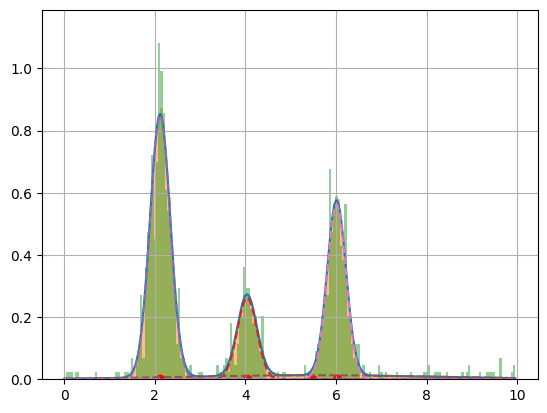

In [7]:
best_gmm = BestGMM(train)
print(best_gmm.n, best_gmm.bic, best_gmm.gmm.gmm._n_parameters())
best_gmm.gmm.plot_gmm()

In [10]:
bests = [BestGMM(train[train['after_noon'] == i]) for i in range(0,6)]

0 : 2 -0.5088190926383497 531.6703807385976 851.6426521977179
params 5


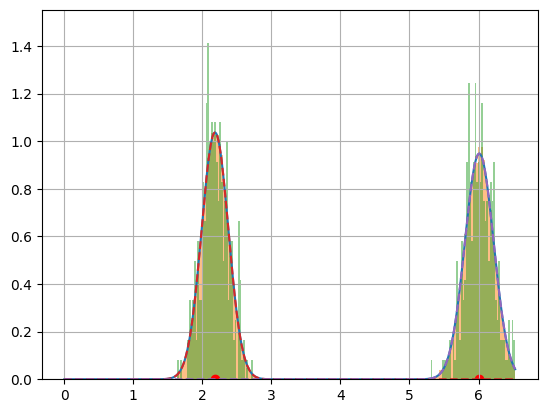

1 : 1 0.13613793628267426 -18.017246884558674 199.2677234709863
params 2


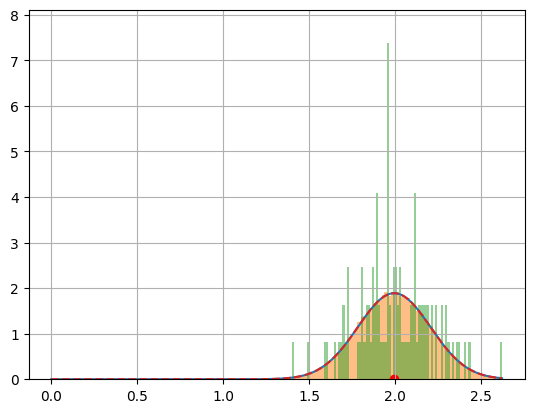

2 : 1 0.16531314509965983 -23.85228864795579 394.39040528532377
params 2


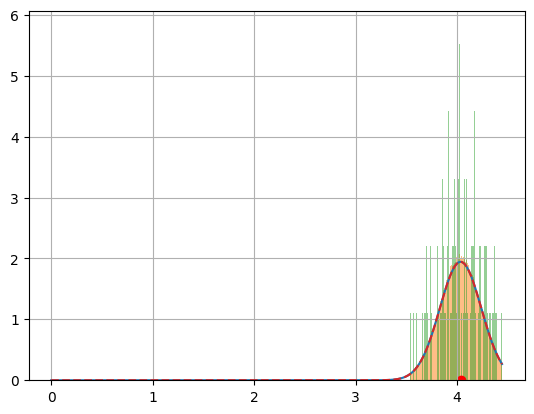

3 : 2 -2.368133365026271 496.6525239351946 684.1720082814459
params 5


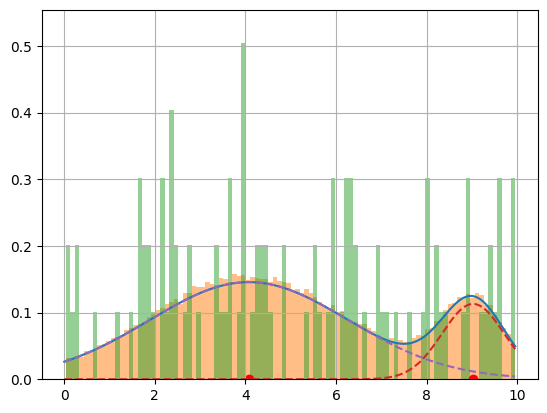

4 : 4 -0.9518541743105408 236.99806043024228 271.6626844742003
params 11


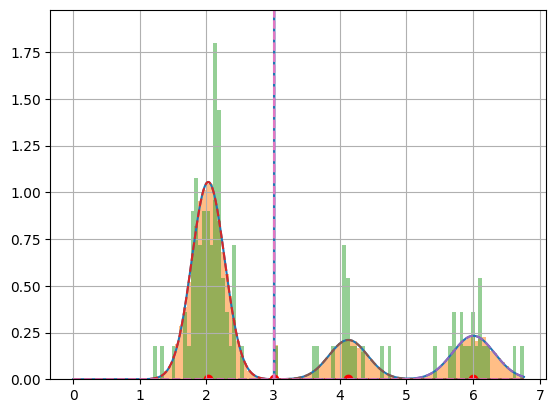

5 : 4 3.7539658459662006 -19.835841422886904 32.5766014146487
params 11


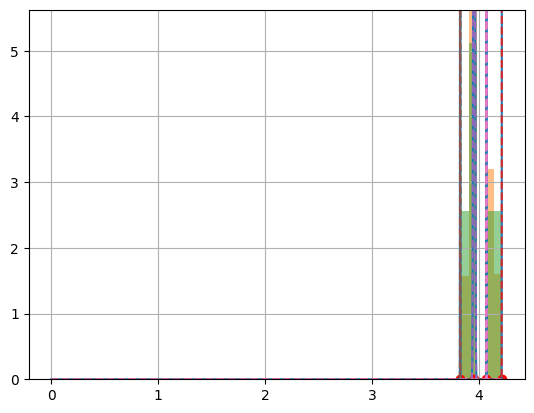

211.06436766287925


In [11]:
overall_score = 0
overall_params = 0
for i, best in enumerate(bests):
    overall_score += best.gmm.gmm.score(best.gmm.x)
    overall_params += 1 + best.gmm.gmm._n_parameters()
    print(i, ':', best.n, best.gmm.gmm.score(best.gmm.x), best.bic, best_gmm.gmm.gmm.bic(best.gmm.x))
    print('params', best.gmm.gmm._n_parameters())
    best.gmm.plot_gmm()

overall_score /= len(bests)
overall_bic = -2 * overall_score * train.shape[0] + (overall_params - 1) * np.log(train.shape[0])
print(overall_bic)


In [12]:
bests2 = [BestGMM(train[train['bullshit'] == i]) for i in range(0,3)]

0 : 4 -1.2647776874430714 839.568825313505 848.3089628083014
params 11


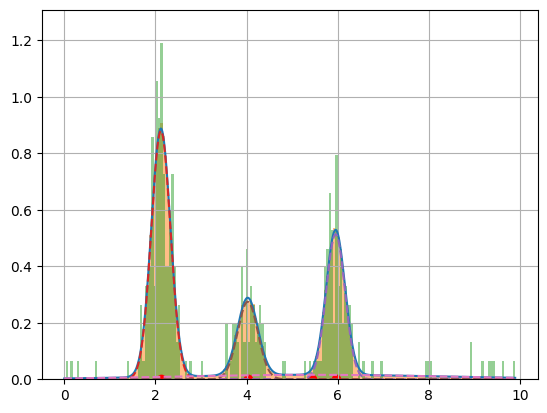

1 : 4 -1.1905072058568185 738.3468095464461 745.8733292734589
params 11


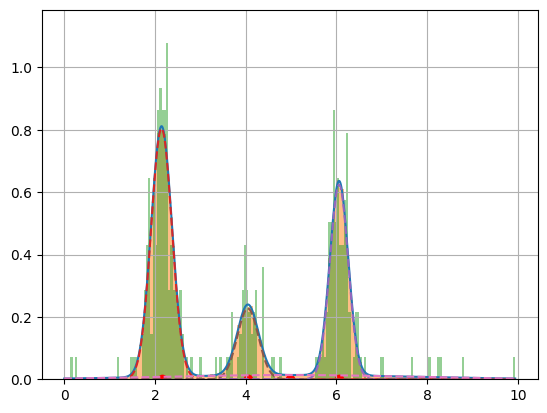

2 : 4 -1.0973418092802136 730.0711247578383 739.2587882800897
params 11


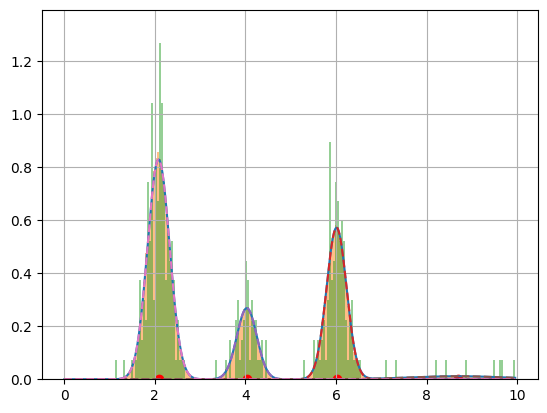

2357.622762679082


In [13]:
overall_score = 0
overall_params = 0
for i, best in enumerate(bests2):
    overall_score += best.gmm.gmm.score(best.gmm.x)
    overall_params += 1 + best.gmm.gmm._n_parameters()
    custom_bic = -2 * best.gmm.gmm.score(best.gmm.x) * best.gmm.x.shape[0] + best.gmm.gmm._n_parameters() * np.log(best.gmm.x.shape[0])
    print(i, ':', best.n, best.gmm.gmm.score(best.gmm.x), best.bic, best_gmm.gmm.gmm.bic(best.gmm.x))
    print('params', best.gmm.gmm._n_parameters())
    best.gmm.plot_gmm()

overall_score /= len(bests2)
overall_bic = -2 * overall_score * train.shape[0] + (overall_params - 1) * np.log(train.shape[0])
print(overall_bic)